In [ ]:
!pip install pandas_profiling==2.9.0 -U -q

     |████████████████████████████████| 258 kB 22.3 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 4.7 MB 48.5 MB/s 
     |████████████████████████████████| 675 kB 46.2 MB/s 
     |████████████████████████████████| 812 kB 38.6 MB/s 
     |████████████████████████████████| 38.2 MB 22 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Importing the libraries for data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
# Importing the dataset
URL = 'https://drive.google.com/file/d/1fLX0XxkbSXatVevvndyqkBDxNOgWcUHP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df = pd.read_csv(path)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,NaN
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0


## Exploratory data analysis

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(df, explorative=True)
# ProfileReport gives basic overview of the dataset that helps to decide for the next steps in data exploration

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

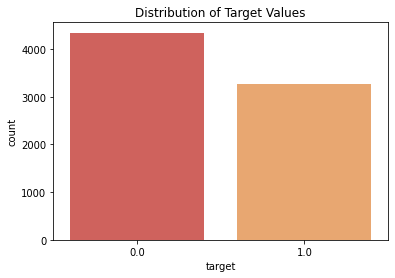

In [ ]:
# Distribution of target values to assess the proportion of distaster and non-disaster values
myPalette = sns.set_palette(sns.color_palette("Spectral"))
sns.countplot(x = "target", data = df, palette = myPalette)
plt.title("Distribution of Target Values")
plt.show()
# The diference in 0 and 1 target can be geglected, the dataset is sifficiently balanced


In [ ]:
# Misssing values overview to determine columns and data to delete
df.info()
print("\nMissing data")
df.isnull().sum()
# Including 'keyword' and 'location' would mean loosing more than 3600 datapoints (not considering the need to delete missing target values which are often in different rows)
# The columns 'location' should be deleted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB

Missing data


id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

# Distributions of different types of words and characters

Text(0.5, 1.0, 'Distribution of Number of Words')

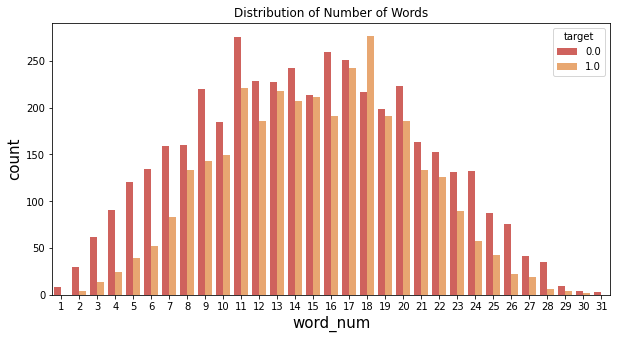

In [ ]:
df_EDA = df.copy()
# Distribution of number of words
df_EDA['word_num'] = df_EDA['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize = (10,5))
res =sns.countplot(x="word_num",hue="target", data = df_EDA, palette = myPalette)
res.set_xlabel('word_num',size=15)
res.set_ylabel('count',size=15)
plt.title("Distribution of Number of Words")
# The values target=0 tend to have higher number of rows with lower number of words. This is caused primarily by the fact that there are more target=0 rows than target=1
# No further processing to change proportion of target=1 and target=0 is needed

In [ ]:
# Most common words list to decide for necessary cleaning
a = Counter(" ".join(df_EDA[df_EDA["target"]==0].text).split()).most_common(100)
pd.DataFrame(a)

,0,1
0,the,1524
1,a,1115
2,to,1099
3,I,938
4,and,840
...,...,...
95,go,58
96,think,58
97,can't,56
98,3,55


In [ ]:
# Making dataframes of most common words for target=0 and target=1
common_w_0 = Counter(" ".join(df_EDA[df_EDA["target"]==0].text).split()).most_common(15)
common_w_0=pd.DataFrame(common_w_0 )
common_w_1 = Counter(" ".join(df_EDA[df_EDA["target"]==1].text).split()).most_common(50)
common_w_1=pd.DataFrame(common_w_1)


Text(0.5, 1.0, 'Distribution of Most Common Words')

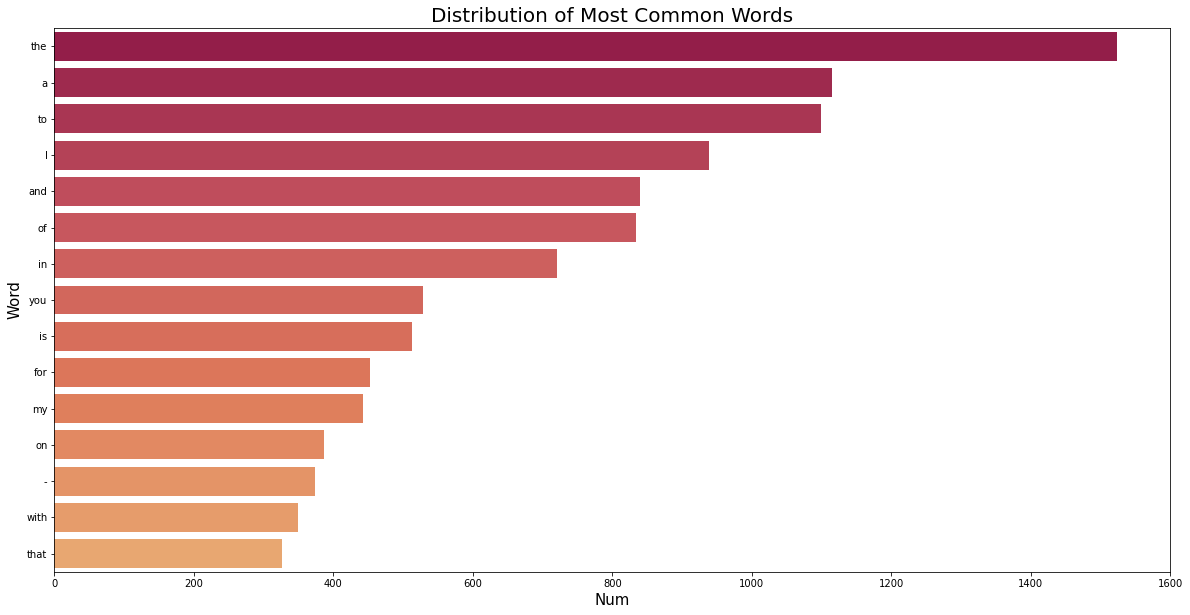

In [ ]:
#Most common words for target=0
plt.figure(figsize = (20,10))
res =sns.barplot(y=common_w_0[0], x=common_w_0[1],palette = sns.color_palette("Spectral", 51))
res.set_xlabel('Num',size=15)
res.set_ylabel('Word',size=15)
plt.title("Distribution of Most Common Words", size =20)
# It can be seen that stopwords represents a considerable part of the text
# To prevent the loss of the structural information of text the model will be first trained and tested on data with stopwords and then without stopwords
# Punctuation should be deleted


Text(0, 0.5, 'Word')

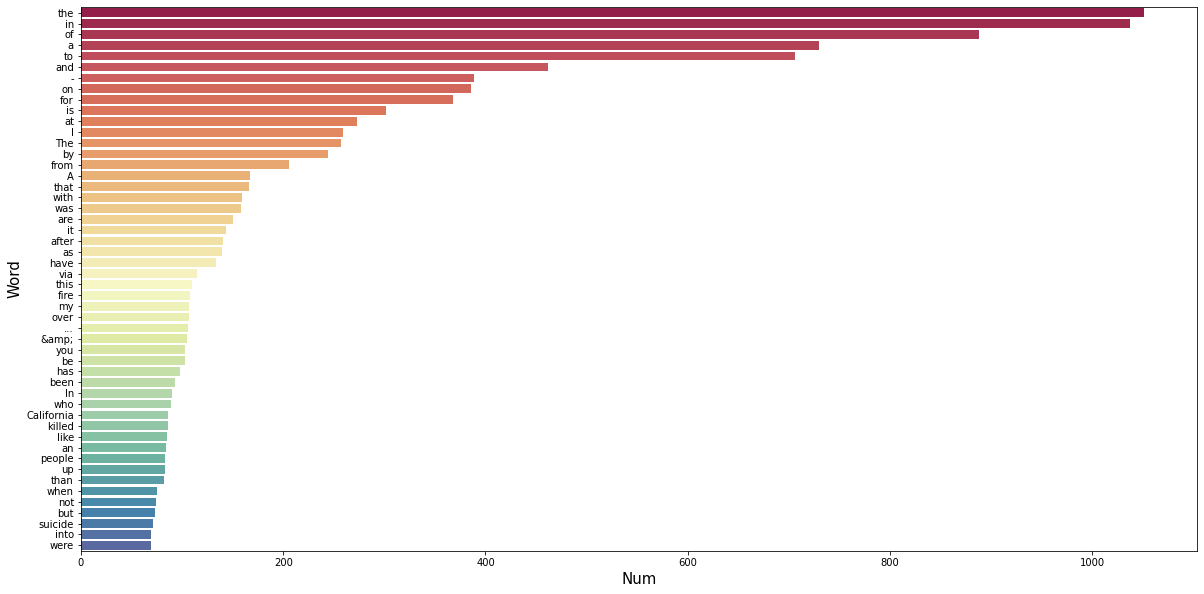

In [ ]:
#Most common words for target=1
plt.figure(figsize = (20,10))
res =sns.barplot(y=common_w_1[0], x=common_w_1[1],palette = sns.color_palette("Spectral", 51))
res.set_xlabel('Num',size=15)
res.set_ylabel('Word',size=15)
# The results are comparable with the target=0
# To ensure the high accuray of testing, the same data cleaning will be applied to both target=0 adn target=1

Text(0.5, 1.0, 'Distribution of Stopwords')

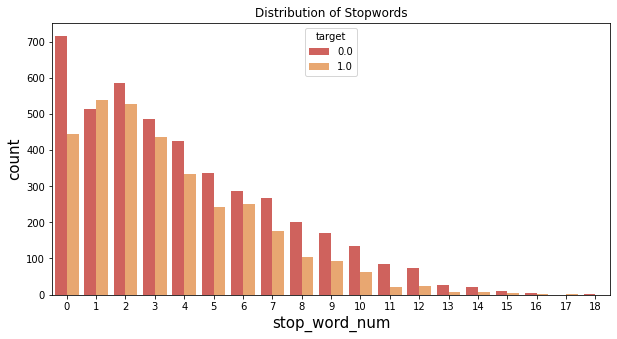

In [ ]:
#Number of stop words in row
stop_words=list(stopwords.words("english"))
df_EDA['stop_word_num'] = df_EDA['text'].apply(lambda x: len([exp for exp in str(x).split() if exp in stop_words]))
plt.figure(figsize = (10,5))
res =sns.countplot(x="stop_word_num",hue = 'target', data = df_EDA, palette = myPalette)
res.set_xlabel('stop_word_num',size=15)
res.set_ylabel('count',size=15)
plt.title("Distribution of Stopwords")
# It can be seen that the number of stopwords is generally lower than number of other words
# The model can be trained with stop-words without running risk of high bias

Text(0.5, 1.0, 'Distribution of URLs')

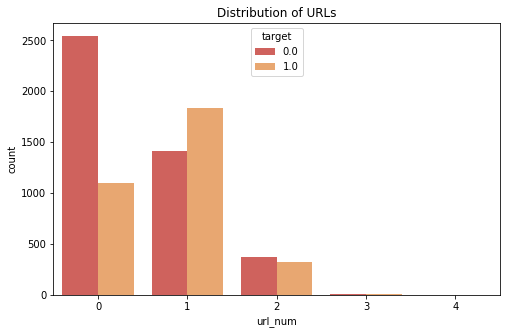

In [ ]:
# Number of rows containing certain number of URLs
plt.figure(figsize = (8,5))
df_EDA['url_num'] = df['text'].apply(lambda x: len([exp for exp in str(x).split() if 'http' in exp]))
sns.countplot(x="url_num", data = df_EDA,hue = 'target', palette = sns.color_palette("Spectral"))
res.set_xlabel('stop_word_num',size=15)
res.set_ylabel('count',size=15)
plt.title("Distribution of URLs")
# The number of URLs is not high but considering the length of URLs and the fact that it does not add meaning to the text, the column should be deleted

Text(0.5, 1.0, 'Distribution of Punctuation')

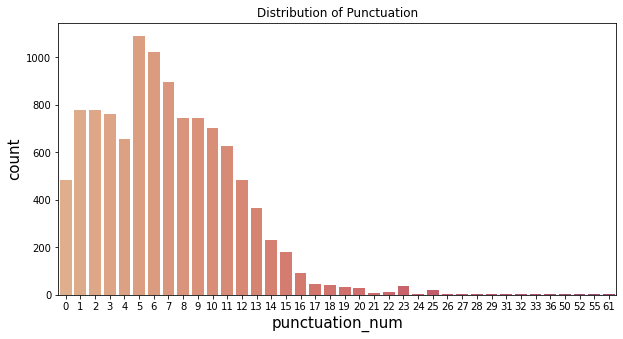

In [ ]:
# Number of rows containing certain number of special characters and punctuation (including !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~)
df_EDA['punctuation_num'] = df_EDA['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
plt.figure(figsize = (10,5))
res =sns.countplot(x="punctuation_num", data = df_EDA, palette= sns.color_palette("flare", 62))
res.set_xlabel('punctuation_num',size=15)
res.set_ylabel('count',size=15)
plt.title("Distribution of Punctuation")
# It can be seen that the punctuation can not be neglected
# Because punctuation does not bring any meaning because it can be part of spelling mistake it would only confuse the model
# Punctuation should be deleted

Number of newlines woth new line characeter


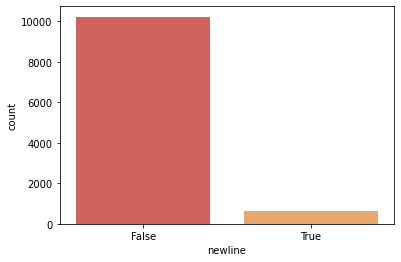

<Figure size 720x360 with 0 Axes>

In [ ]:
# Newline characters in row
df_EDA['newline'] = df['text'].apply(lambda x: True if ('\n'in x) else False)
sns.countplot(x='newline', data = df_EDA)
plt.figure(figsize = (10,5))
res.set_xlabel('newline',size=15)
res.set_ylabel('count',size=15)
print('Number of newlines woth new line characeter')
# There is a part of data containing the new line characters
# It is often part of the words and would only confuse the model and result in loss of information

In [ ]:
# 15 most common locations
df.location.value_counts().head(15)
# This helps us see the distibution of the number of locations of dataframe
# It can be also seen that the column contains not only countries but also cities

USA                141
New York           109
United States       65
London              58
Canada              42
Nigeria             40
India               35
Worldwide           35
Los Angeles, CA     34
UK                  33
Kenya               32
Washington, DC      31
Mumbai              28
United Kingdom      26
Australia           25
Name: location, dtype: int64

In [ ]:
# Dataframe of most common locations sorted descending by number of occurances with target=1
df_location = pd.concat([df, pd.get_dummies(df.target)], axis=1).groupby('location').sum().drop(['target', 'id'], axis=1)
df_location['sum'] = df_location.apply(sum, axis=1)
df_location = df_location.rename(columns={0:'target_0', 1:'target_1' })
df_location.sort_values(by='target_1', ascending=False)[:15]
# This helps us see if any group of locations has higher influence on the target values (also see the Bubble plot)
# The number of missing data and the high number of cities and states indicate that the same location does not repeat many times in the dataset and therefore will not help to recognize tweet

,target_0,target_1,sum
location,,,
USA,37,67,104
United States,23,27,50
Nigeria,6,22,28
India,4,20,24
Mumbai,3,19,22
UK,11,16,27
New York,55,16,71
London,29,16,45
"Washington, DC",6,15,21


Text(0.5, 1.0, 'Bubble Plot of Locations')

<Figure size 864x504 with 0 Axes>

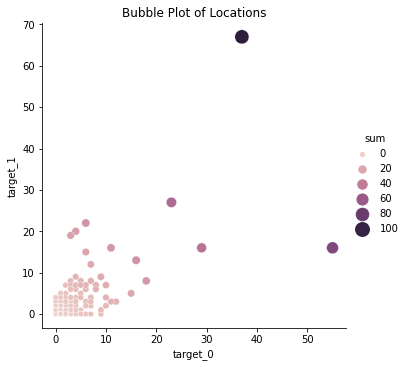

In [ ]:
# Bubble plot of locations (see the previous Datasframe)
plt.figure(figsize = (12,7))
rel_loc = sns.relplot(
    data=df_location,
    x='target_0', y='target_1', size='sum',hue = 'sum',
    palette=myPalette, sizes=(20, 200))
plt.title("Bubble Plot of Locations")
# Most of the locations have a similar number of target=1 and target=0 values
# The column can be deleted because most of the data have similar number of target=0  and target=1
# Using the column wouldn't help the model to recognise the tweets

In [ ]:
# Dataframe of most common keywords sorted descending by number of occurances with target=1
df_keywords = pd.concat([df, pd.get_dummies(df.target)], axis=1).groupby('keyword').sum().drop(['target', 'id'], axis=1)
df_keywords['sum'] = df_keywords.apply(sum, axis=1)
df_keywords = df_keywords.rename(columns={0:'target_0', 1:'target_1' })
df_keywords.sort_values(by='target_1', ascending=False)[:15]
# The trend is similar as in the 'location' column
# The number of missing data is low but the high number of keywords and low sum indicates that the same keyword do not repeat many times in the dataset and therefore will not help the model

,target_0,target_1,sum
keyword,,,
derailment,0,39,39
wreckage,0,39,39
outbreak,1,39,40
typhoon,1,37,38
debris,0,37,37
oil%20spill,1,37,38
suicide%20bomb,3,32,35
rescuers,3,32,35
suicide%20bombing,1,32,33


Text(0.5, 1.0, 'Bubble Plot of Keywords')

<Figure size 864x504 with 0 Axes>

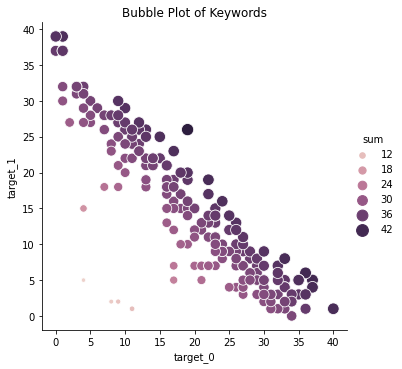

In [ ]:
# Bubble plot of keywords (see the previous Datasframe)
plt.figure(figsize = (12,7))
rel_key = sns.relplot(
    data=df_keywords ,
    x='target_0', y='target_1', size='sum',hue = 'sum',
    palette=myPalette, sizes=(20, 150))
plt.title("Bubble Plot of Keywords")
# It is obvious that a considerable number of keywords have high number of one category of 'target'

# Data preprocessing

In [ ]:
df_c = df.copy()
df_c=df_c.drop(columns=['keyword','id', 'location'])
df_c=df_c.dropna()

In [ ]:
#transforming to lower-case text
df_c.text=df_c.text.apply(lambda x:x.lower() )
#Removing square brackets
df_c.text=df_c.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
#Removing URLs and links
df_c.text=df_c.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
#Removing puncuation !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
df_c.text=df_c.text.apply(lambda x: ''.join([char for char in x if char not in string.punctuation]) )
#Removes newline characters
df_c.text=df_c.text.apply(lambda x:re.sub('\n' , '', x) )
#Remove words containing numbers
df_c.text=df_c.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
'''
#remove stop-words 
sw = list(stopwords.words("english"))
df_c.text=df_c.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))
'''
# Removinf the words that do not addd much emaning but are common in 50 most common words
df_c.text=df_c.text.apply(lambda x:re.sub('im', '', x) )
df_c.text=df_c.text.apply(lambda x:re.sub('amp', '', x) )
df_c.text=df_c.text.apply(lambda x:re.sub('te', '', x) )


In [ ]:
#The following were used to demonstate the result of celaning and to check that the dataset was cleaned correctly

Text(0, 0.5, 'count')

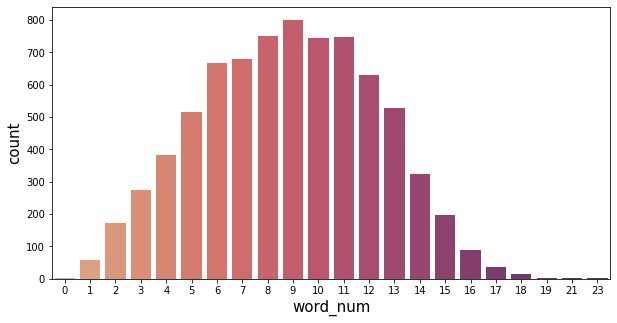

In [ ]:
#Number of words distribution after the cleaning
df_c['word_num'] = df_c['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize = (10,5))
res =sns.countplot(x="word_num", data = df_c,  palette= sns.color_palette("flare", 23))

res.set_xlabel('word_num',size=15)
res.set_ylabel('count',size=15)


Text(0, 0.5, 'count')

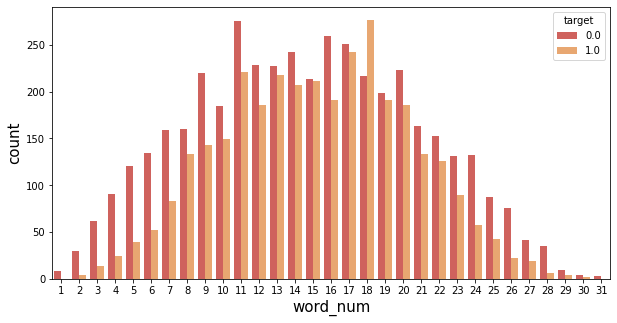

In [ ]:
#Distribution of number of words after the cleaning
df_c['word_num'] = df_c['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize = (10,5))
res =sns.countplot(x="word_num",hue="target", data = df_EDA, palette = myPalette)
res.set_xlabel('word_num',size=15)
res.set_ylabel('count',size=15)

In [ ]:
common_w_0 = Counter(" ".join(df_c[df_c["target"]==0].text).split()).most_common(50)
common_w_0=pd.DataFrame(common_w_0 )
common_w_1 = Counter(" ".join(df_c[df_c["target"]==1].text).split()).most_common(50)
common_w_1=pd.DataFrame(common_w_1)


Text(0, 0.5, 'Word')

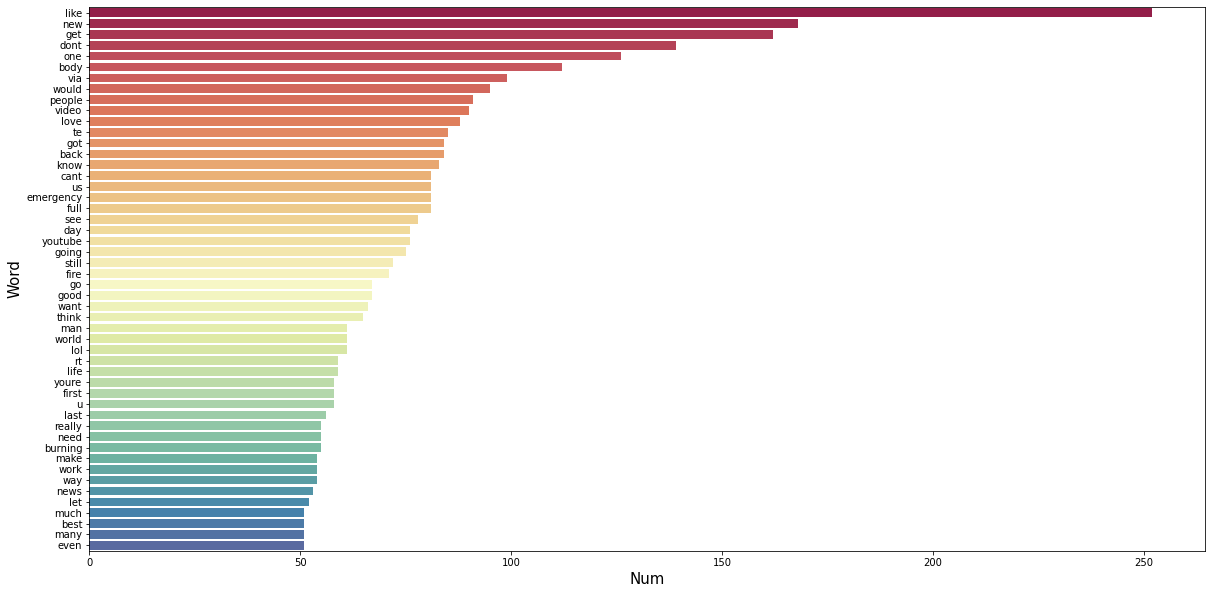

In [ ]:
#Most common words for target=0 after cleaning
plt.figure(figsize = (20,10))
res =sns.barplot(y=common_w_0[0], x=common_w_0[1],palette = sns.color_palette("Spectral", 51))
res.set_xlabel('Num',size=15)
res.set_ylabel('Word',size=15)

Text(0, 0.5, 'Word')

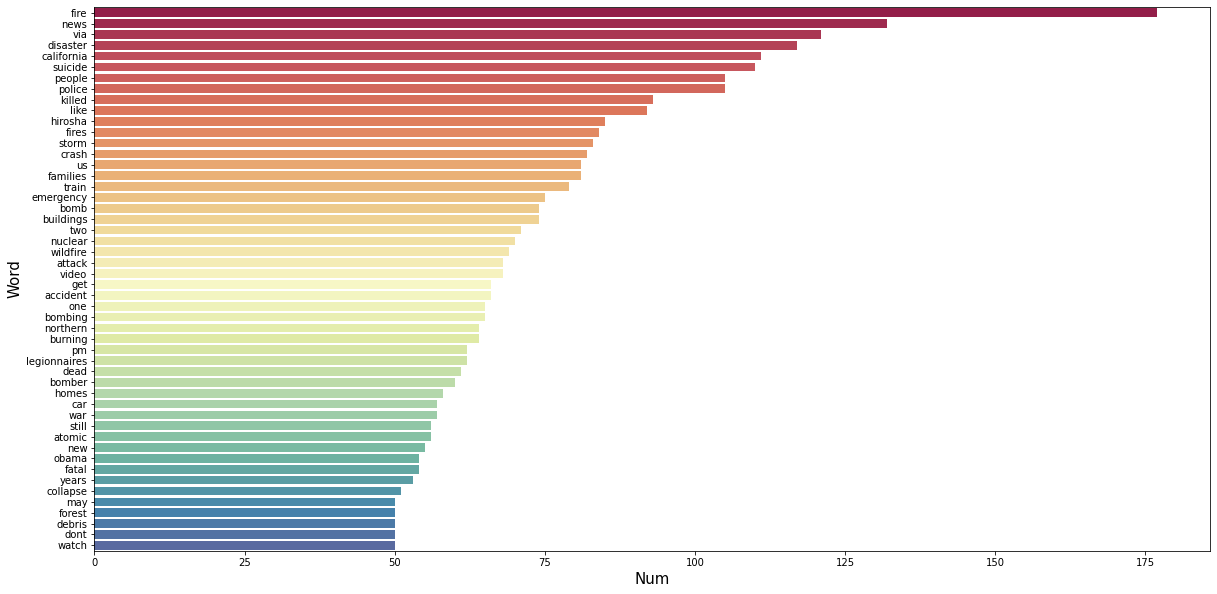

In [ ]:
#Most common words for target=0 after cleaning
plt.figure(figsize = (20,10))
res =sns.barplot(y=common_w_1[0], x=common_w_1[1],palette = sns.color_palette("Spectral", 51))
res.set_xlabel('Num',size=15)
res.set_ylabel('Word',size=15)